In [19]:
using MatrixNetworks
using Distributions
using Clustering
using BenchmarkTools, Compat
using DelimitedFiles
using SparseArrays
using LinearAlgebra
using EllipsoidalGraphEmbedding
using Random
using Arpack
using Plots, LaTeXStrings
using IterTools
using Statistics
using Measures

### LFR toy benchmark with modularity as descriptor matrix

 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 127 iterations
  0.448186 seconds (3.41 k allocations: 177.569 MiB, 14.22% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 10
Number of updates: 

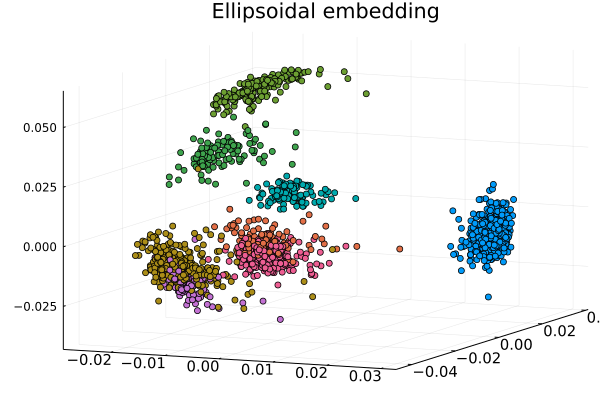

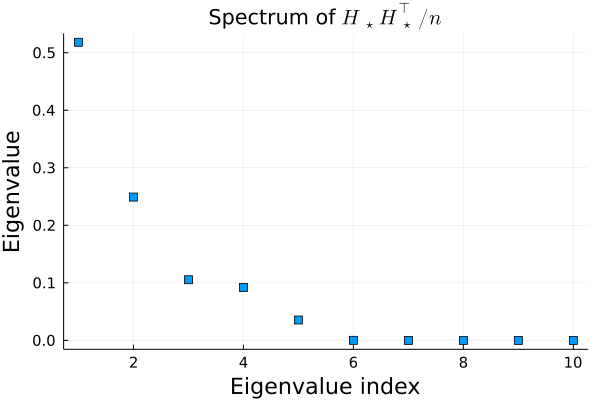

3
Modularity: 0.4864869338628159
Number of communities: 9
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.5181054257687758, 0.24905559441768196, 0.10536111041946293, 0.09206004245829529, 0.035375468728254214]
 -------------------------------------------- 
  0.913399 seconds (263.79 k allocations: 337.157 MiB, 14.63% gc time)
NMI with ground truth: 0.999061114796606
embedding effective dim= 

5


In [27]:
set = "toy_1"#"toy_2"

community_true = readdlm("Data/LFR_data/"*set*"_communities.txt");
list = readdlm("Data/LFR_data/"*set*"_edgeList.txt");
list = list .+ 1 #indices start from 1
# construct adjacency matrix
A = adj_matrix_cc(list)

# converting to int array
community_true = convert(Array{Int64},community_true)
N = length(community_true)

# number of columns of initial guess
d0 = 10

# number of centroids thrown in embedding
n_clusters = 100;

# shape of embedding
shape = "Ellipsoidal";

# Initialization
community = zeros(Int64,N,1)
x_embed,community,sigma =  @time sphere_embed_cluster(A, d0,shape, n_clusters)

# normalized multual information
nmi = mutualinfo(community_true,community)
println("NMI with ground truth: ", nmi)
# beware run twice to get timings without compilation time

p1 = Plots.plot(x_embed[1,:],x_embed[2,:],x_embed[3,:],seriestype=:scatter, color = community_true, legend = false,xtickfontsize=10,ytickfontsize=10, xguidefontsize=15, yguidefontsize=15,title= "Ellipsoidal embedding")
savefig("figures/LFR_"*set*"_embedding.pdf")
display(p1)

p2 = Plots.plot(1:length(sigma),sigma.^2/N,seriestype=:scatter, legend = false,yticks = 0:0.1:0.5,xtickfontsize=10,ytickfontsize=10, xguidefontsize=15, yguidefontsize=15, marker=:square)
Plots.xlabel!("Eigenvalue index")
Plots.ylabel!("Eigenvalue")
Plots.title!(L"Spectrum of $H_\star H_\star^\top/n$")
savefig("figures/LFR_"*set*"_spectrum.pdf")
display(p2)

println("embedding effective dim= ",dim_eff(sigma,0.01))

### Power EU graph with Laplacian as descriptor matrix

 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 202 iterations
  1.137013 seconds (7.79 k allocations: 807.047 MiB, 14.97% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 20
Number of updates: 

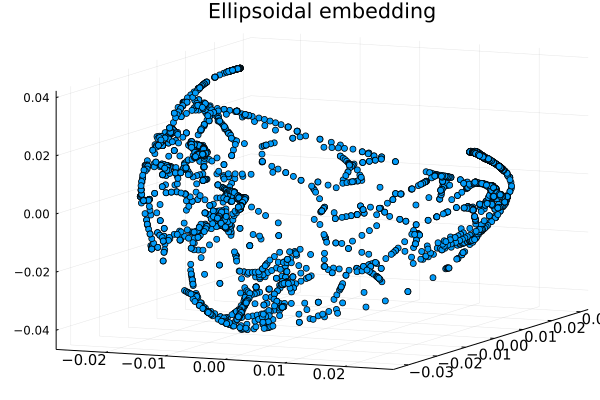

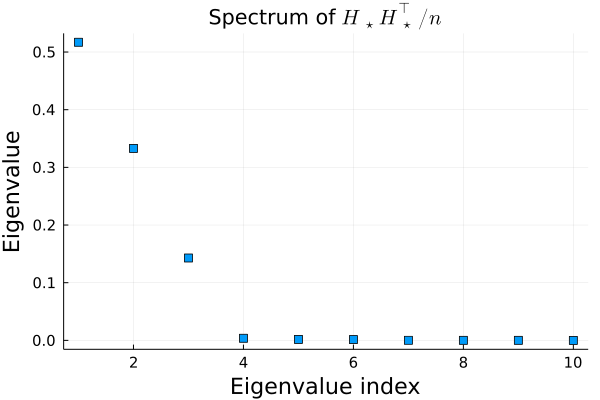

14
Modularity: 0.8804478246621515
Number of communities: 17
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.5168265161458389, 0.3329098685860433, 0.14286931740310305, 0.0036373562839172088, 0.00177267912945466]
 -------------------------------------------- 
  2.753766 seconds (1.09 M allocations: 1.486 GiB, 10.90% gc time)


In [21]:
descriptor = "Laplacian" # "Modularity" #

# Loading data
list = readdlm("Data/PowerEU/ElistPowerEU.txt");
A = adj_matrix_cc(list)

# number of columns of initial guess
d0 = 20;

# number of centroids thrown in embedding
n_clusters = 100;

# shape of embedding
shape = "Ellipsoidal"

# Initialization
N = size(A,1)
community = zeros(Int64,N,1)
x_embed,community,singular =  @time sphere_embed_cluster(A, d0,shape, n_clusters)
# beware run twice to get timings without compilation time

p1 = Plots.plot(x_embed[1,:],x_embed[2,:],x_embed[3,:],seriestype=:scatter, legend = false,xtickfontsize=10,ytickfontsize=10, xguidefontsize=15, yguidefontsize=15,title= "Ellipsoidal embedding")
savefig("figures/PowerEU_ellipsoidal_embedding.pdf")
display(p1)

p2 = Plots.plot(1:10,singular[1:10].^2/N,seriestype=:scatter, legend = false,xtickfontsize=10,ytickfontsize=10, xguidefontsize=15, yguidefontsize=15, marker=:square)
Plots.xlabel!("Eigenvalue index")
Plots.ylabel!("Eigenvalue")
Plots.title!(L"Spectrum of $H_\star H_\star^\top/n$")
savefig("figures/PowerEU_ellipsoidal_spectrum.pdf")
display(p2)

Plotting the graph edges

In [22]:
using Graphs, GraphPlot
using CairoMakie
CairoMakie.activate!(type="png")
set_theme!(resolution=(400, 400))
using GraphMakie: graphplot
using GraphMakie: graphplot!
using CairoMakie.Colors

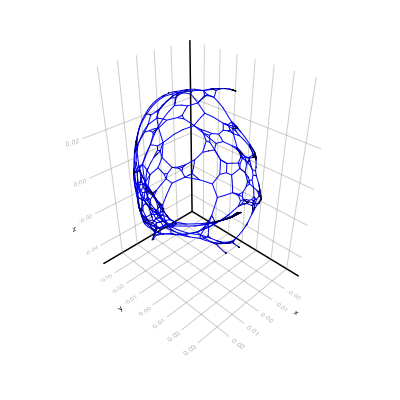

In [23]:
g = Graph(A)
x = x_embed'
function mylayout(g)
    # create iterator going over x-coord and y-coord 
    return Point.(zip(x[:, 1], x[:, 2],x[:, 3]))
end

f, ax, p = graphplot(g; layout=mylayout,edge_color=:blue,node_size=1,edge_width=1)    
f

### Spectral embedding using laplacian eigenvectors

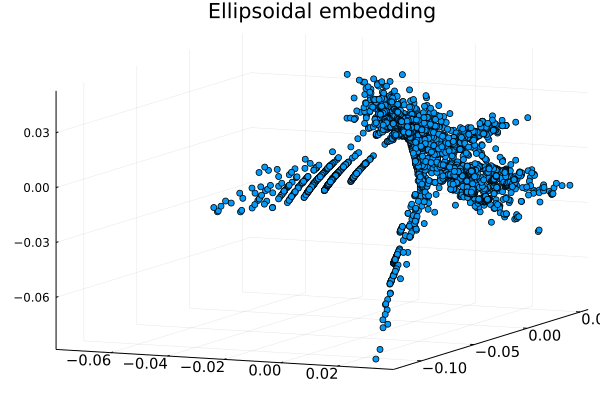

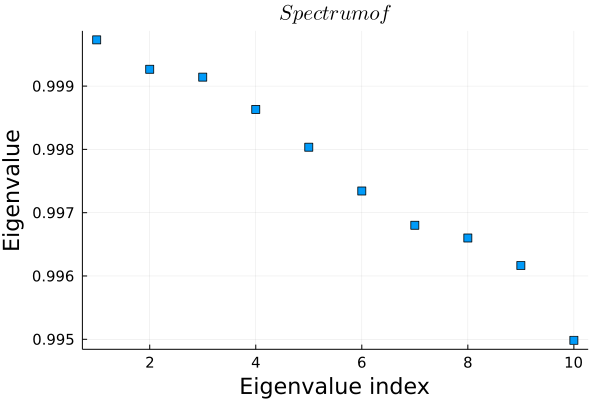

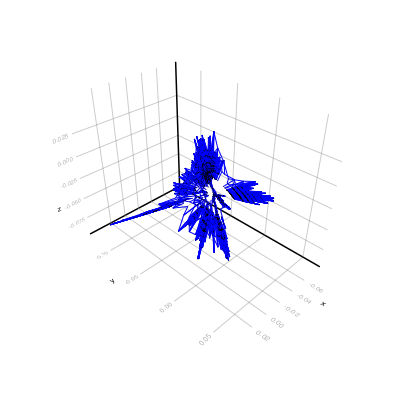

In [24]:
d = sum(A,dims=2)
D = Diagonal(1 ./ vec(sqrt.(d)))
p0 = sqrt.(d/sum(d))

L = D * A * D - p0 * p0'

λ, V = eigs(L, nev = 10, which=:LR)
x_embed_spectral = (V[:,1:3])'

p1 = Plots.plot(x_embed_spectral[1,:],x_embed_spectral[2,:],x_embed_spectral[3,:],seriestype=:scatter, legend = false,xtickfontsize=10,ytickfontsize=10, xguidefontsize=15, yguidefontsize=15,title= "Ellipsoidal embedding")
savefig("figures/PowerEU_Laplacian_embedding.pdf")
display(p1)

p2 = Plots.plot(1:10,λ, legend = false ,seriestype=:scatter,xtickfontsize=10,ytickfontsize=10, xguidefontsize=15, yguidefontsize=15, marker=:square)
Plots.xlabel!("Eigenvalue index")
Plots.ylabel!("Eigenvalue")
Plots.title!(L"Spectrum of ")
savefig("figures/PowerEU_Laplacian_spectrum.pdf")
display(p2)

g = Graph(A)
x = x_embed_spectral'
function mylayout(g)
    # create iterator going over x-coord and y-coord 
    return Point.(zip(x[:, 1], x[:, 2],x[:, 3]))
end

f, ax, p = graphplot(g; layout=mylayout,edge_color=:blue,node_size=1,edge_width=1)    
f

Toy example of spin foam

 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 43 iterations
  0.000803 seconds (797 allocations: 130.484 KiB)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 2
Number of updates: 1
Modularity: 0.4666666666666666
Number of communities: 3
 -------------------------------------------- 
The squared singular values divided by N : 
[0.5002706011641415, 0.4997293988358589]
 -------------------------------------------- 
  0.007926 seconds (18.28 k allocations: 2.177 MiB)


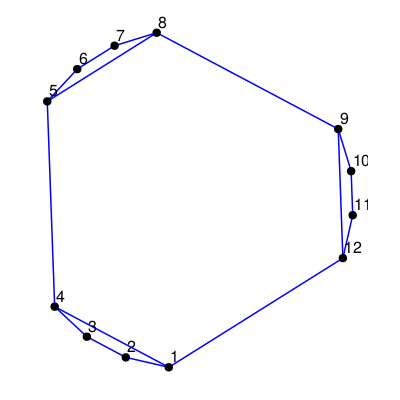

In [25]:
A = zeros(Int64,12,12)
A[1,2] = 1
A[1,4] = 1
A[2,3] = 1
A[3,4] = 1

A[5,6] = 1
A[5,8] = 1
A[6,7] = 1
A[7,8] = 1

A[9,10] = 1
A[9,12] = 1
A[10,11] = 1
A[11,12] = 1

A[4,5] = 1
A[8,9] = 1
A[12,1] = 1

A = sparse(A + A')

N = size(A,1)

n_clusters = 10
shape = "Spherical"
d0 = 2

community = zeros(Int64,N,1);
x_embed,community,sigma =  @time sphere_embed_cluster(A, d0,shape, n_clusters)

g = Graph(A)
x = x_embed'
function mylayout(g)
    # create iterator going over x-coord and y-coord 
    return Point.(zip(x[:, 1], x[:, 2]))
end

lab = vec(["1" "2" "3" "4" "5" "6" "7" "8" "9" "10" "11" "12"])
f, ax, p = graphplot(g; layout=mylayout,nlabels=lab,nlabels_distance=2,edge_color=:blue)    

hidedecorations!(ax); hidespines!(ax)
ax.aspect = DataAspect()
f
     